# Introduction

Some subtypes are hub subtypes, and some are spoke subtypes. Over all of the subtypes represented, which ones are at the animal-human interface? Of those, how many are hub subtypes, and how many are spoke subtypes?

In [1]:
import networkx as nx
import pandas as pd
import statsmodels.api as sm 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import math

from collections import Counter
from mpl_toolkits.basemap import Basemap 
from matplotlib.path import Path 
from hiveplot import HivePlot


%matplotlib inline
%load_ext autoreload


In [2]:
def golden_figsize(height):
    """
    Assuming height dimension is the shorter one, the width should be:
    (1 + 5**0.5)/2
    
    This function thus returns the (width, height) tuple which is
    computed to be in a golden ratio.
    """
    width = height * (1 + 5**0.5) / 2
    return (width, height)



In [3]:
G = nx.read_gpickle('20141103 All IRD Final Graph.pkl')

In [4]:
# Let's get a list of all hosts represented in the graph.
hosts = []
for n, d in G.nodes(data=True):
    host = d['host_species']
    if '/' in host:
        host = host.split('/')[0]
    if 'null' in host:
        host = 'Unknown'
    hosts.append(host)
# set(hosts)
print('In total, there are {0} unique hosts represented. They are: '.format(len(set(hosts))))
print(set(hosts))

In total, there are 142 unique hosts represented. They are: 
set(['Horse', 'American Green-Winged Teal', 'Unknown', 'Heron', 'Grey Heron', 'Whiskered Tern', 'Northern Shoveler', 'Redhead', 'Murre', 'Whooper Swan', 'Bird', 'Peregrine Falcon', 'Red-Crested Pochard', 'Wild Chicken', 'Myna', 'Bufflehead', 'Red-Necked Stint', "Bewick's Swan", 'Ring-Necked Duck', 'Knot', 'White-Winged Scoter', 'Green-Winged Teal', 'Sanderling', 'Magpie', 'Stork', 'Pheasant', 'Barnacle Goose', 'Goose', 'Weasel', 'Openbill Stork', 'Quail', 'Panda', 'Parakeet', 'Pintail', 'Ruddy Turnstone', 'Magpie Robin', 'Glaucous Gull', 'Gull', 'Saker Falcon', 'Common Eider', 'Redhead Duck', 'Rook', 'Finch', 'Rhea', 'Muscovy Duck', 'Common Murre', 'Scaup', 'Lesser Scaup', 'Coot', 'Black-Headed Gull', 'White-Rumped Sandpiper', 'Guineafowl', 'Ferret', 'Aquatic Bird', 'Eurasian Eagle-Owl', 'Domestic Cat', 'Little Egret', 'Duck', 'Sharp-Tailed Sandpiper', 'Black Duck', 'Ostrich', 'Tufted Duck', 'Waterfowl', 'Swine', 'Teal', 'Soo

In [5]:
# Let's also get a list of countries represented in the graph.
countries = []
for n, d in G.nodes(data=True):
    country = d['country']
    countries.append(country)
    
print('In total, there are {0} unique countries represented. They are: '.format(len(set(countries))))
print(set(countries))

In total, there are 86 unique countries represented. They are: 
set(['Canada', 'Cambodia', 'Argentina', 'Bolivia', 'Saudi Arabia', 'Slovenia', 'Guatemala', 'Spain', 'Netherlands', 'New Zealand', 'Pakistan', 'United Arab Emirates', 'Guam', 'India', 'South Korea', 'Turkey', 'Afghanistan', 'Bangladesh', 'Viet Nam', 'Mongolia', 'France', 'Peru', 'Laos', 'Norway', 'Singapore', 'China', 'Dominican Republic', 'Finland', 'Cote dIvoire', 'Indonesia', 'Sweden', 'Russia', 'Romania', 'Portugal', 'South Africa', 'Malaysia', 'Senegal', 'Uganda', 'Hungary', 'Brazil', 'Ontario', 'Kuwait', 'Luxembourg', 'Nigeria', 'Ecuador', 'Czech Republic', 'Australia', 'Iran', 'Bhutan', 'El Salvador', 'Chile', 'Belgium', 'Thailand', 'Iraq', 'Hong Kong', 'Georgia', 'Denmark', 'Philippines', 'Croatia', 'Switzerland', 'Estonia', 'Lebanon', 'Colombia', 'Taiwan', 'Nicaragua', 'Qatar', 'Italy', 'USA', 'Sudan', 'Nepal', 'Israel', 'Iceland', 'Zambia', 'Austria', 'Germany', 'Kazakhstan', 'Poland', '-N/A-', 'Kyrgyzstan', 'New

In [6]:
# Because different countries will have different animals at the animal–human interface, we will need to assign them
# a wild/domestic status accordingly. 

# Let's first get a report of every combination of host and country represented. 

country_host = dict()
for n, d in G.nodes(data=True):
    country = d['country']
    if country not in country_host.keys():
        country_host[country] = set()
    host = d['host_species']
    if '/' in host:
        host = host.split('/')[0]
    if 'null' in host:
        host = 'Unknown'
    country_host[country].add(host)
    
# country_host

In [7]:
# Make a list of country-host tuples for Nichola to do coding.
l = []
for country, hosts in country_host.items():
    for host in hosts:
        l.append((country, host))
        
df = pd.DataFrame(l)
df.columns = ['Country', 'Species']
df.to_csv('Country-Species to be Coded by Nichola.csv')

In [8]:
# Nichola has coded them as wild/domestic and avian/mammalian. I will add these into the graph. 

# Load the data
df = pd.read_csv('Country-Species_coded.csv', index_col=0)

# Make it into a dicitonary where each entry is (country, species):habitat/setting
ecotype_map = dict()

for row, data in df.iterrows():
    country = data['Country']
    species = data['Species']
    ecotype = data['Habitat/setting']

    ecotype_map[(country, species)] = ecotype

ecotype_map

{('-N/A-', 'Ferret'): 'Domestic',
 ('-N/A-', 'Human'): 'Human',
 ('Afghanistan', 'Chicken'): 'Domestic',
 ('Afghanistan', 'Chicken/Avian'): 'Domestic',
 ('Argentina', 'Horse'): 'Domestic',
 ('Argentina', 'Human'): 'Human',
 ('Argentina', 'Rosy-Billed Pochard'): 'Wild',
 ('Argentina', 'Rosy-Billed Pochard/Avian'): 'Wild',
 ('Australia', 'Avian'): 'Unknown',
 ('Australia', 'Black Duck'): 'Wild',
 ('Australia', 'Black Duck/Avian'): 'Wild',
 ('Australia', 'Chicken'): 'Domestic',
 ('Australia', 'Chicken/Avian'): 'Domestic',
 ('Australia', 'Duck'): 'Wild',
 ('Australia', 'Duck/Avian'): 'Wild',
 ('Australia', 'Emu'): 'Wild',
 ('Australia', 'Emu/Avian'): 'Wild',
 ('Australia', 'Human'): 'Human',
 ('Australia', 'Red-Necked Stint'): 'Wild',
 ('Australia', 'Red-Necked Stint/Avian'): 'Wild',
 ('Australia', 'Sharp-Tailed Sandpiper'): 'Wild',
 ('Australia', 'Sharp-Tailed Sandpiper/Avian'): 'Wild',
 ('Australia', 'Sooty Tern'): 'Wild',
 ('Australia', 'Sooty Tern/Avian'): 'Wild',
 ('Australia', 'Starl

In [9]:
# Add the ecotype into each node.
for n, d in G.nodes(data=True):
    country = d['country']
    species = d['host_species']
    if '/' in species:
        species = species.split('/')[0]
    if 'null' in species:
        species = 'Unknown'


    
    G.node[n]['ecotype'] = ecotype_map[(country, species)]

In [10]:
# Add reassortant status for each node.
for n, d in G.nodes(data=True):
    in_edge_types = set([d['edge_type'] for sc, sk, d in G.in_edges(n, data=True)])
    if 'reassortant' in in_edge_types:
        G.node[n]['reassortant'] = True
    elif 'full_complement' in in_edge_types:
        G.node[n]['reassortant'] = False
    else:
        G.node[n]['reassortant'] = False

In [11]:
G.nodes(data=True)[0]

('A/mallard/Interior Alaska/6MP0160AR1/2006',
 {'collection_date': Timestamp('2006-08-12 00:00:00'),
  'country': 'USA',
  'ecotype': 'Wild',
  'host_species': 'Mallard/Avian',
  'reassortant': False,
  'state': 'Interior Alaska',
  'subtype': 'H3N8'})

For every virus node for which the ecotype is 'Domestic', do a single layer traceback to see if it has "wild" ancestors. If it does, grab the subtypes involved at the wild ancestors.

In [12]:
### Helper functions go into this cell.
def has_wild_ancestors(G, node):
    b = False
    for n in G.predecessors(node):
        if G.node[n]['ecotype'] == 'Wild':
            b = True
            break
    return b
        
def has_farm_ancestors(G, node):
    b = False
    for n in G.predecessors(node):
        if G.node[n]['ecotype'] == 'Domestic' and G.node[n]['host_species'] != 'Human':
            b = True
            break
    return b

def has_human_ancestors(G, node):
    b = False
    for n in G.predecessors(node):
        if G.node[n]['host_species'] == 'Human':
            b = True
            break
    return b
          
def clean_host_species(species):
    if species == 'null':
        species = 'Unknown'
    if '/' in species:
        species = species.split('/')[0]
    return species
        
def get_predecessors_attr(G, node, attr):
    attr_values = []
    for n in G.predecessors(node):
        if is_wild_node(G, n):
            if attr == 'host_species':
                species = clean_host_species(G.node[n][attr])
                attr_values.append(species)
            else:
                attr_values.append(G.node[n][attr])
    return attr_values

def is_wild_node(G, node):
    d = G.node[node]
    if d['ecotype'] == 'Wild':
        return True
    else:
        return False

def is_human_node(G, node):
    d = G.node[node]
    if d['ecotype'] == 'Human':
        return True
    else:
        return False
    
def is_farm_node(G, node):
    d = G.node[node]
    if d['ecotype'] == 'Domestic' and d['host_species'] != 'Human':
        return True
    else: 
        return False
    
def is_domestic_node(G, node):
    d = G.node[node]
    if d['ecotype'] == 'Domestic' or d['ecotype'] == 'Human':
        return True
    else:
        return False
    
def is_unknown_node(G, node):
    d = G.node[node]
    if d['ecotype'] == 'Unknown':
        return True
    else:
        return False
    
def get_predecessors_combinations(G, node):
    # Gets the predecessors' subtype-host-country combination if the predecessor is a wild isolate.
    subtype_host_country = []
    for n in G.predecessors(node):
        if is_wild_node(G, n):
            subtype = G.node[n]['subtype']
            country = G.node[n]['country']
            host = clean_host_species(G.node[n]['host_species'])
            
            subtype_host_country.append((subtype, host, country))
    return subtype_host_country

def is_at_wild_dom_interface(G, node):
    d = G.node[node]
    if is_domestic_node(G, node) and has_wild_ancestors(G, node):
        return True
    else:
        return False

def is_reassortant(G, node):
    d = G.node[node]
    return d['reassortant']

def subtype_suffix(G, node):
    if is_human_node(G, node):
        return '_hum'
    elif is_wild_node(G, node):
        return '_wld'
    elif is_farm_node(G, node):
        return '_frm'
    elif is_unknown_node(G,node):
        return '_wld'
    else:
        return '_wld'

In [13]:
subtypes_wild_dom = Counter() # counter of subtypes at wild-domestic/human interface
subtypes_total = Counter()

countries_wild_dom = Counter()
countries_total = Counter()

hosts_wild_dom = Counter()
hosts_total = Counter()

for n, d in G.nodes(data=True):
    ancestral_subtypes = set(get_predecessors_attr(G, n, 'subtype')) #called helper function
    ancestral_hosts = set(get_predecessors_attr(G, n, 'host_species')) #called helper function
    ancestral_countries = set(get_predecessors_attr(G, n, 'country')) #called helper function

    if is_at_wild_dom_interface(G, n): #called helper function
        for subtype in ancestral_subtypes:
            subtypes_wild_dom[subtype] += 1
        for host in ancestral_hosts:
            hosts_wild_dom[host] += 1
        for country in ancestral_countries:
            countries_wild_dom[country] += 1
            
    for subtype in ancestral_subtypes:
        subtypes_total[subtype] += 1
    for host in ancestral_hosts:
        hosts_total[host] += 1
    for country in ancestral_countries:
        countries_total[country] += 1 
            
subtypes_wild_dom

Counter({'H5N1': 92, 'H1N1': 54, 'H9N2': 40, 'H7N1': 29, 'H5N2': 27, 'H2N3': 26, 'H6N1': 22, 'H3N8': 21, 'H11N9': 19, 'H6N2': 19, 'H5N8': 14, 'H10N7': 14, 'H7N7': 13, 'H4N2': 9, 'H4N6': 9, 'H3N2': 8, 'H2N1': 8, 'H3N6': 7, 'Mixed': 7, 'H2N9': 7, 'H7N3': 5, 'H7N9': 4, 'H2N2': 4, 'H11N2': 3, 'H5N3': 3, 'H4N8': 3, 'H10N9': 3, 'H7N2': 2, 'H11N3': 2, 'H12N5': 2, 'H3N1': 2, 'H4N3': 2, 'H6N5': 2, 'H1N2': 2, 'H10N5': 2, 'H6N7': 2, 'H12N8': 1, 'H3N9': 1, 'H3N7': 1, 'H6N8': 1, 'H4N9': 1, 'H10N8': 1, 'H6N6': 1, 'H7N8': 1, 'H6N3': 1, 'H1N4': 1, 'H10N1': 1, 'H1N3': 1, 'H1N5': 1, 'H9N1': 1, 'H10N6': 1, 'H9N5': 1, 'H8N4': 1})

In [14]:
# Normalize the counts by total sampling effort
subtypes_normalized = dict()

def normalize_counts(counts, totals):
    normalized = dict()
    for k, v in counts.items():
        normalized[k] = float(v) / totals[k]
    return normalized

subtypes_normalized = normalize_counts(subtypes_wild_dom, subtypes_total)
hosts_normalized = normalize_counts(hosts_wild_dom, hosts_total)
countries_normalized = normalize_counts(countries_wild_dom, countries_total)

In [15]:
# Analyze: What are the wild viruses at the wild/domestic interface donating when it comes to reassortment?
segments = []
for n, d in G.nodes(data=True):
    if is_domestic_node(G, n) and is_reassortant(G, n):
        in_edge_segments = set([tuple(d['segments'].keys()) for sc, sk, d in G.in_edges(n, data=True) if is_wild_node(G, sc)])
        for seg in in_edge_segments:
            segments.append(seg)
            
# Compile them into a counter.
from collections import Counter

counts = Counter()
for segcomb in segments:
    for seg in segcomb:
        counts[seg] += 1
counts

Counter({3: 228, 6: 217, 1: 192, 7: 173, 8: 169, 5: 166, 2: 164, 4: 146})

In [16]:
# Find every subtype, host, and country combination.
subtype_host_country = []

for n, d in G.nodes(data=True):
    if (d['ecotype'] == 'Domestic' or d['host_species'] == 'Human') and has_wild_ancestors(G, n):
        subtype_host_country.extend(get_predecessors_combinations(G, n))

In [17]:
def ols_fit_predict(xs, ys):

    est = sm.OLS(ys, xs) 
    est = est.fit()
    print(est.summary())

    x_prime = np.linspace(min(xs), max(xs), 100)[:,np.newaxis]
    y_hat = est.predict(x_prime[:,0]) 
    
    rsquared = '{0:.2f}'.format(est.rsquared)
    
    return x_prime, y_hat, rsquared

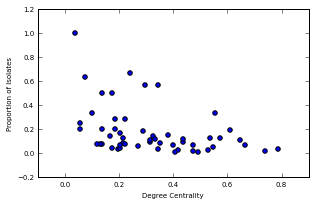

In [18]:
# Let's put the subtype centralities in context with the subtypes at the wild/domestic interface
subtype_centralities = pd.read_csv('Subtype Reassortment Centralities.csv', index_col=0)
subtype_centralities.set_index('Subtype', inplace=True)
subtype_centralities

subtype_wd_df = pd.DataFrame(subtypes_normalized.values(), index=subtypes_normalized.keys())
subtype_wd_df.columns = ['Proportion of Isolates']
subtype_wd_df.join(subtype_centralities).plot(kind='scatter', x='Degree Centrality', y='Proportion of Isolates', grid=False, figsize=golden_figsize(3))

In [19]:
subtype_wd_df.sort('Proportion of Isolates', ascending=False)

,Proportion of Isolates
H3N7,1.000000
H2N2,0.666667
H5N8,0.636364
H7N1,0.568627
H5N1,0.564417
H10N5,0.500000
H12N8,0.500000
H9N2,0.336134
H6N7,0.333333
H4N3,0.285714


In [20]:
# Let's call a "hub subtype" something that is connected to more than half of the other subtypes represented in the dataset. 
# Given this, how many hub subtypes are represented in the wild/domestic interface?

# First, let's figure out which subtypes are hub subtypes.
hub_subtypes = subtype_centralities.join(subtype_wd_df, how='inner')
hub_subtypes['Hub Status'] = hub_subtypes['Degree Centrality'] > 0.6
hub_subtypes.sort('Proportion of Isolates', ascending=False)

,Degree Centrality,Proportion of Isolates,Hub Status
H3N7,0.037037,1.000000,False
H2N2,0.240741,0.666667,False
H5N8,0.074074,0.636364,False
H7N1,0.342593,0.568627,False
H5N1,0.296296,0.564417,False
H10N5,0.175926,0.500000,False
H12N8,0.138889,0.500000,False
H9N2,0.555556,0.336134,False
H6N7,0.101852,0.333333,False
H4N3,0.222222,0.285714,False


In [21]:
# What is the proportion of reassortant viruses at each interface that move in the "towards humans" direction? 
# The interfaces are:
# 1. Wild-to-human
# 2. Wild-to-domestic animal
# 4. Domestic-to-human

# For comparison, we will do proportion of reassortants within each ecotype.

# # Create a bipartite directed graph of wild subtypes donating segments to domestic reassortant viruses. 
# subtypeG = nx.DiGraph()



# NOTE: The idiosyncracies of this notebook dictate that "domestic" animals are really "farm" animals, as reflected
# in the function names. Keep note of this!

def count_interface_reassortants(G):
    """
    Counts the number of reassortants at the human, domestic and wild animal interfaces.
    """
    
    # counter of the number of isolates that are reassortant or not.
    host_groups = ['wild', 'human', 'domestic']
    interfaces = dict()
    for h in host_groups:
        interfaces[h] = dict()
        for h2 in host_groups:
            interfaces[h][h2] = Counter()


    for sc, sk, d in G.edges(data=True):
        if is_wild_node(G, sc):
            if is_human_node(G, sk):
                if is_reassortant(G, sk):
                    interfaces['wild']['human']['reassortant'] += 1
                else:
                    interfaces['wild']['human']['not reassortant'] += 1
            if is_farm_node(G, sk):
                if is_reassortant(G, sk):
                    interfaces['wild']['domestic']['reassortant'] += 1
                else:
                    interfaces['wild']['domestic']['not reassortant'] += 1
            if is_wild_node(G, sk):
                if is_reassortant(G, sk):
                    interfaces['wild']['wild']['reassortant'] += 1
                else:
                    interfaces['wild']['wild']['not reassortant'] += 1
        if is_farm_node(G, sc):
            if is_human_node(G, sk):
                if is_reassortant(G, sk):
                    interfaces['domestic']['human']['reassortant'] += 1
                else:
                    interfaces['domestic']['human']['not reassortant'] += 1
            if is_farm_node(G, sk):
                if is_reassortant(G, sk):
                    interfaces['domestic']['domestic']['reassortant'] += 1
                else:
                    interfaces['domestic']['domestic']['not reassortant'] += 1
            if is_wild_node(G, sk):
                if is_reassortant(G, sk):
                    interfaces['domestic']['wild']['reassortant'] += 1
                else:
                    interfaces['domestic']['wild']['not reassortant'] += 1
        if is_human_node(G, sc):
            if is_human_node(G, sk):
                if is_reassortant(G, sk):
                    interfaces['human']['human']['reassortant'] += 1
                else:
                    interfaces['human']['human']['not reassortant'] += 1
            if is_farm_node(G, sk):
                if is_reassortant(G, sk):
                    interfaces['human']['domestic']['reassortant'] += 1
                else:
                    interfaces['human']['domestic']['not reassortant'] += 1
            if is_wild_node(G, sk):
                if is_reassortant(G, sk):
                    interfaces['human']['wild']['reassortant'] += 1
                else:
                    interfaces['human']['wild']['not reassortant'] += 1  
                    
    return interfaces
                    
interfaces = count_interface_reassortants(G)
interfaces

{'domestic': {'domestic': Counter({'not reassortant': 2711, 'reassortant': 876}),
  'human': Counter({'reassortant': 399, 'not reassortant': 45}),
  'wild': Counter({'reassortant': 162, 'not reassortant': 137})},
 'human': {'domestic': Counter({'not reassortant': 576, 'reassortant': 122}),
  'human': Counter({'not reassortant': 10613, 'reassortant': 123}),
  'wild': Counter({'not reassortant': 10, 'reassortant': 2})},
 'wild': {'domestic': Counter({'reassortant': 365, 'not reassortant': 149}),
  'human': Counter({'reassortant': 69, 'not reassortant': 3}),
  'wild': Counter({'reassortant': 2680, 'not reassortant': 2126})}}

In [22]:
# # Plot the proportion of isolates at the interface between wild and domestic animal interface

# fig = plt.figure(figsize=(1.5,1.5))
# ax = fig.add_subplot(111)
# ax.pie(interface.values())
# ax.annotate('reassortant', xy=(0.5, 1.0), xycoords=('axes fraction'), ha='center', va='top', fontsize=7)
# ax.annotate('not reassortant', xy=(0.5, 0), xycoords=('axes fraction'), ha='center', va='bottom', fontsize=7)
# # ax.legend()
# ax.set_aspect('equal')
# ax.annotate('b.', xy=(0,1), xycoords='figure fraction', ha='left', va='top')

# plt.savefig('Proportion of Reassortants.pdf')

In [23]:
# Perform 1000 permutation tests to get distribution of proportion of reassortants at wild/domestic ecotypes.
# To do this test, shuffle the ecotype labels amongst a copied version of the network. 
# BE FOREWARNED: THIS PART TAKES A WHILE TO RUN!!!

from IPython.display import clear_output
from collections import defaultdict

proportion_reassortant = []
shuffled_hostgroupG = G.copy()

host_groups = ['wild', 'human', 'domestic']
shuffled_hg_int = dict()
for h in host_groups:
    shuffled_hg_int[h] = dict()
    for h2 in host_groups:
        shuffled_hg_int[h][h2] = defaultdict(list)

for i in range(1000):
    if i % 10 == 0:
        clear_output()
    print(i)
    from random import shuffle
    
    # Shuffle the order of the labels labels
    ecotype_labels = [d['ecotype'] for n, d in shuffled_hostgroupG.nodes(data=True)]
    shuffle(ecotype_labels)
    
    
    # Add back the labels into the graph
    for i, (n, d) in enumerate(shuffled_hostgroupG.nodes(data=True)):
        shuffled_hostgroupG.node[n]['ecotype'] = ecotype_labels[i]

    # Count the number of reassortants and non-reassortants at wild/dom interfaces under a permutated model
#     interface_shuffled = Counter()
#     for n,d in shuffled_hostgroupG.nodes(data=True):
#         # filter for reassortant viruses at wild-domestic interface
#         if is_at_wild_dom_interface(shuffled_hostgroupG, n) and not is_reassortant(shuffled_hostgroupG, n): 
#             interface_shuffled['Not Reassortant'] += 1
#         if is_at_wild_dom_interface(shuffled_hostgroupG, n) and is_reassortant(shuffled_hostgroupG, n): 
#             interface_shuffled['Reassortant'] += 1
            
#     # Compute the proportion
#     prop = interface_shuffled['Reassortant']/float(interface_shuffled['Not Reassortant'])
#     proportion_reassortant.append(prop)
    
    interfaces_shuffled = count_interface_reassortants(shuffled_hostgroupG)
    
    for hg1, v in interfaces_shuffled.items():
        for hg2, v2 in v.items():
            shuffled_hg_int[hg1][hg2]['not reassortant'].append(v2['not reassortant'])
            shuffled_hg_int[hg1][hg2]['reassortant'].append(v2['reassortant'])
    
shuffled_hg_int

990
991
992
993
994
995
996
997
998
999


{'domestic': {'domestic': defaultdict(<type 'list'>, {'reassortant': [168, 219, 237, 289, 230, 234, 214, 204, 253, 192, 281, 230, 218, 194, 230, 223, 266, 187, 229, 260, 238, 227, 200, 232, 221, 214, 235, 251, 229, 205, 225, 229, 225, 228, 225, 241, 260, 206, 213, 243, 283, 229, 194, 222, 204, 258, 212, 216, 279, 256, 227, 189, 235, 220, 216, 265, 267, 246, 263, 208, 266, 225, 192, 244, 277, 222, 228, 255, 222, 239, 258, 277, 185, 248, 212, 212, 200, 245, 218, 222, 226, 194, 243, 205, 216, 250, 220, 230, 208, 223, 220, 215, 239, 235, 232, 181, 204, 211, 213, 227, 212, 261, 278, 191, 251, 173, 253, 199, 224, 215, 198, 255, 215, 249, 225, 228, 199, 207, 207, 226, 219, 201, 200, 219, 244, 216, 224, 253, 212, 232, 268, 198, 254, 197, 230, 206, 208, 210, 214, 213, 228, 204, 218, 240, 201, 175, 230, 190, 203, 186, 204, 213, 201, 209, 237, 217, 264, 201, 226, 184, 191, 221, 269, 209, 251, 233, 254, 224, 242, 264, 182, 241, 215, 179, 253, 245, 217, 237, 216, 213, 275, 195, 230, 206, 207, 225, 

In [24]:
shuffled_hg_means = dict()
shuffled_hg_stdev = dict()
for hg1, v in shuffled_hg_int.items():
    shuffled_hg_means[hg1] = dict()
    shuffled_hg_stdev[hg1] = dict()
    for hg2, v2 in v.items():
        shuffled_hg_means[hg1][hg2] = dict()
        shuffled_hg_stdev[hg1][hg2] = dict()
        for k, l in v2.items():
            shuffled_hg_means[hg1][hg2][k] = np.mean(l)
            shuffled_hg_stdev[hg1][hg2][k] = np.std(l)
            
shuffled_hg_means
# shuffled_hg_stdev

{'domestic': {'domestic': {'not reassortant': 279.06,
   'reassortant': 223.92599999999999},
  'human': {'not reassortant': 681.74599999999998,
   'reassortant': 593.05999999999995},
  'wild': {'not reassortant': 301.68900000000002,
   'reassortant': 264.21199999999999}},
 'human': {'domestic': {'not reassortant': 738.91200000000003,
   'reassortant': 555.57000000000005},
  'human': {'not reassortant': 4489.0770000000002,
   'reassortant': 1498.1690000000001},
  'wild': {'not reassortant': 1992.3330000000001, 'reassortant': 665.072}},
 'wild': {'domestic': {'not reassortant': 326.17899999999997,
   'reassortant': 245.72200000000001},
  'human': {'not reassortant': 1984.9929999999999,
   'reassortant': 662.99000000000001},
  'wild': {'not reassortant': 879.87400000000002,
   'reassortant': 293.87900000000002}}}

In [25]:
interfaces

{'domestic': {'domestic': Counter({'not reassortant': 2711, 'reassortant': 876}),
  'human': Counter({'reassortant': 399, 'not reassortant': 45}),
  'wild': Counter({'reassortant': 162, 'not reassortant': 137})},
 'human': {'domestic': Counter({'not reassortant': 576, 'reassortant': 122}),
  'human': Counter({'not reassortant': 10613, 'reassortant': 123}),
  'wild': Counter({'not reassortant': 10, 'reassortant': 2})},
 'wild': {'domestic': Counter({'reassortant': 365, 'not reassortant': 149}),
  'human': Counter({'reassortant': 69, 'not reassortant': 3}),
  'wild': Counter({'reassortant': 2680, 'not reassortant': 2126})}}

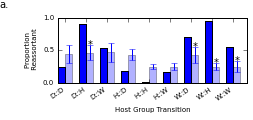

In [26]:
# Plot a bar chart of the expected proportion of reassortants at each interface.

host_groups = ['domestic', 'human', 'wild']
groups = ['D::D', 'D::H', 'D::W', 'H::D', 'H::H', 'H::W', 'W::D', 'W::H', 'W::W']
from __future__ import division

reassortant_data = []
reassortant_perm = []
reassortant_perm_sd = []

non_reassortant_data = []
non_reassortant_perm = []
non_reassortant_perm_sd = []
for h1 in host_groups:
    for h2 in host_groups:
        reassortant_data.append(interfaces[h1][h2]['reassortant'] / np.sum(interfaces[h1][h2].values()))
        reassortant_perm.append(shuffled_hg_means[h1][h2]['reassortant'] / np.sum(shuffled_hg_means[h1][h2].values()))
        reassortant_perm_sd.append(shuffled_hg_stdev[h1][h2]['reassortant'] / np.sum(shuffled_hg_means[h1][h2].values()))
        
        non_reassortant_data.append(interfaces[h1][h2]['not reassortant'] / np.sum(interfaces[h1][h2].values()))
        non_reassortant_perm.append(shuffled_hg_means[h1][h2]['not reassortant'] / np.sum(shuffled_hg_means[h1][h2].values()))
        non_reassortant_perm_sd.append(shuffled_hg_stdev[h1][h2]['not reassortant'] / np.sum(shuffled_hg_means[h1][h2].values()))


fig = plt.figure(figsize=(3.5,1.5))
ax = fig.add_subplot(111)

ind = np.arange(len(groups))
width = 0.35
ax.bar(ind, reassortant_data, width, color='blue', label='R-Data')
ax.bar(ind+width, reassortant_perm, width, color='blue', \
       alpha=0.3, yerr=np.array(reassortant_perm_sd)*3, label='R-Perm')

# ax.bar(ind, non_reassortant_data, width, color='green', bottom=reassortant_data, label='N-Data')
# ax.bar(ind+width, non_reassortant_perm, width, color='green', \
#        alpha=0.3, yerr=np.array(non_reassortant_perm_sd)*3, bottom=reassortant_perm, label='N-Perm')

ax.set_xticks(ind + width)
ax.set_xticklabels(groups, rotation=35, ha='right')
ax.set_ylabel('Proportion \n Reassortant')
ax.set_xlabel('Host Group Transition')
ax.set_yticks([0, 0.5, 1.0])
ax.annotate('*', xy=(1.57, 0.66), xycoords='data', ha='center', va='top')
ax.annotate('*', xy=(6.57, 0.63), xycoords='data', ha='center', va='top')
ax.annotate('*', xy=(7.57, 0.39), xycoords='data', ha='center', va='top')
ax.annotate('*', xy=(8.57, 0.41), xycoords='data', ha='center', va='top')

ax.annotate('a.', xy=(0,1),xycoords='figure fraction', ha='left', va='top')
plt.subplots_adjust(bottom=0.3, right=0.95, left=0.2)
plt.savefig('Proportion Reassortant across All Host Groups.pdf')

In [27]:
def is_at_wild_farm_interface(G, node):
    d = G.node[node]
    if is_farm_node(G, node) and has_wild_ancestors(G, node):
        return True
    else:
        return False
    
def is_at_wild_human_interface(G, node):
    d = G.node[node]
    if is_human_node(G, node) and has_wild_ancestors(G, node):
        return True
    else:
        return False
    
def is_at_farm_human_interface(G, node):
    d = G.node[node]
    if is_human_node(G, node) and has_farm_ancestors(G, node):
        return True
    else:
        return False

def is_at_farm_wild_interface(G, node):
    d = G.node[node]
    if is_wild_node(G, node) and has_farm_ancestors(G, node):
        return True
    else:
        return False
    
def is_at_human_farm_interface(G, node):
    d = G.node[node]
    if is_farm_node(G, node) and has_human_ancestors(G, node):
        return True
    else:
        return False
    
def is_at_human_wild_interface(G, node):
    d = G.node[node]
    if is_wild_node(G, node) and has_human_ancestors(G, node):
        return True
    else:
        return False

In [28]:
# Helper functions for dealing with the node annotations.
def is_wild_subtype(G, node):
    if G.node[node]['ecotype'] == 'wld':
        return True
    else:
        return False
    
def is_farm_subtype(G, node):
    if G.node[node]['ecotype'] == 'frm':
        return True
    else:
        return False
    
def is_human_subtype(G, node):
    if G.node[node]['ecotype'] == 'hum':
        return True
    else:
        return False

In [29]:
# If we perform a traceback up to 5 levels backwards in time, can we count the number of reassortant viruses present?    
# Here are the helper functions to compress the executed code a bit.
def nodes_in_traceback(G, node, num_levels):
    """Returns a list of nodes in the traceback."""
    traced_nodes = []
    traced_nodes.append(node)
    
    for n in traced_nodes:
        if len(nx.shortest_path(G, n, node)) - 1 >= num_levels:
            pass
        else:
            traced_nodes.extend(G.predecessors(n))
    return traced_nodes

def degrees_of_separation(G, node_of_interest, traced_nodes):
    from collections import defaultdict
    """Returns a dictionary of {deg_separation : num_reassortant_nodes}"""
    deg_sep = defaultdict(set) # degrees of separation counts of number of reassortant nodes
    for node in traced_nodes:
        path_length = len(nx.shortest_path(G, node, node_of_interest)) - 1
        if is_reassortant(G, node):
            deg_sep[path_length].add(node)
        if not is_reassortant(G, node) and path_length not in deg_sep.keys():
            deg_sep[path_length] = set()
                        
#     for k, v in deg_sep.items():
#         if len(v) > 500:
#             print(node_of_interest)
    return deg_sep

In [30]:
# Collect nodes of interest. They should be:
# - domestic (animal) or human
# - at the wild-domestic interface.
nodes_of_interest = []
for n, d in G.nodes(data=True):
    if is_domestic_node(G,n) and is_at_wild_dom_interface(G,n):
    # if is_human_node(G,n) and is_at_wild_dom_interface(G,n):
        nodes_of_interest.append(n)

In [31]:
# Get the path lengths traced out.
deg_paths = []
for node in nodes_of_interest:
#     print(node)
    traced_nodes = nodes_in_traceback(G, node, 6)
    deg_paths.append(degrees_of_separation(G, node, traced_nodes))

In [32]:
deg_paths

[defaultdict(<type 'set'>, {0: set(['A/Duck/Nanchang/2-0485/2000']), 1: set(['A/mallard/Netherlands/12/1999', 'A/mallard/Netherlands/11/1999', 'A/chicken/Korea/MS96-CE6/1996', 'A/mallard/Netherlands/13/1999']), 2: set(['A/blue-winged teal/Wisconsin/259/1982', 'A/mallard/Potsdam/178-6/1983', 'A/mallard/Wisconsin/280/1982', 'A/mallard/Potsdam/176/1983', 'A/mallard/Stralsund/41-4/1981', 'A/blue-winged teal/Wisconsin/634/1983', 'A/blue-winged teal/Wisconsin/281/1982', 'A/mallard/Potsdam/177-6/1983', 'A/duck/Nanchang/1904/1992', 'A/mallard/Potsdam/179/1983', 'A/mallard/Wisconsin/1746/1983', 'A/mallard/Saskatchewan/36/1981']), 3: set(['A/mallard/Saskatchewan/17/1981', 'A/pintail duck/ALB/169/1980', 'A/mallard/Wisconsin/856/1982', 'A/mallard/Wisconsin/333/1981', 'A/duck/Altai/1285/1991', 'A/mallard/Alberta/11/91', 'A/mallard/Wisconsin/409/1981', 'A/chicken/Jena/4836/1983', 'A/redhead duck/Alberta/357/1983']), 4: set(['A/mallard duck/ALB/797/1983', 'A/mallard duck/ALB/76/1985', 'A/mallard/Albe

In [33]:
# Count the number of viruses at the wild -> domestic/human interface  that have at least 
# 1 reassortant in their life history vs. 0 reassortants.
num_viruses = 0
num_reassortants = 0
for node in nodes_of_interest:
    num_viruses += 1
    traced_nodes = nodes_in_traceback(G, node, 6)
    
    for source_node in traced_nodes:
        if is_reassortant(G, source_node):
            num_reassortants += 1
            break
    print(num_viruses, num_reassortants)

(1, 1)
(2, 2)
(3, 3)
(4, 4)
(5, 5)
(6, 6)
(7, 7)
(8, 8)
(9, 9)
(10, 9)
(11, 10)
(12, 11)
(13, 12)
(14, 13)
(15, 14)
(16, 15)
(17, 16)
(18, 17)
(19, 18)
(20, 19)
(21, 20)
(22, 20)
(23, 21)
(24, 22)
(25, 23)
(26, 23)
(27, 24)
(28, 24)
(29, 25)
(30, 26)
(31, 27)
(32, 28)
(33, 29)
(34, 30)
(35, 31)
(36, 32)
(37, 33)
(38, 34)
(39, 35)
(40, 36)
(41, 36)
(42, 37)
(43, 37)
(44, 38)
(45, 39)
(46, 40)
(47, 41)
(48, 42)
(49, 42)
(50, 43)
(51, 44)
(52, 45)
(53, 46)
(54, 47)
(55, 48)
(56, 49)
(57, 50)
(58, 51)
(59, 52)
(60, 52)
(61, 53)
(62, 54)
(63, 55)
(64, 56)
(65, 57)
(66, 58)
(67, 59)
(68, 60)
(69, 61)
(70, 61)
(71, 62)
(72, 63)
(73, 64)
(74, 65)
(75, 66)
(76, 67)
(77, 68)
(78, 69)
(79, 70)
(80, 71)
(81, 72)
(82, 72)
(83, 73)
(84, 74)
(85, 75)
(86, 76)
(87, 77)
(88, 78)
(89, 79)
(90, 79)
(91, 80)
(92, 80)
(93, 81)
(94, 82)
(95, 83)
(96, 84)
(97, 85)
(98, 86)
(99, 87)
(100, 88)
(101, 89)
(102, 90)
(103, 91)
(104, 92)
(105, 93)
(106, 94)
(107, 95)
(108, 95)
(109, 96)
(110, 97)
(111, 98)
(112, 99

In [34]:
# AAAAnnddd the final answer is: 88% 
print(float(num_reassortants)/num_viruses)

0.893034825871


In [35]:
# Combine deg_paths results into a compiled dictionary.
combined = dict()
for i in range(0, 7):    
    combined[i] = []

for c in deg_paths:
    for k, v in c.items():
        combined[k].append(len(v))

In [36]:
# Count the number of host species, and proportion of them, at each level of the traceback.
from collections import defaultdict

isolate_counts = defaultdict(list)

for c in deg_paths:
    for k, v in c.items():
        if len(v) > 0:
            isolate_counts[k].extend(list(v))
        if len(v) == 0:
            isolate_counts[k].append('Non-Reassortant')
            
isolate_counts

defaultdict(<type 'list'>, {0: ['A/Duck/Nanchang/2-0485/2000', 'A/Canada-AB/RV1532/2009', 'Non-Reassortant', 'Non-Reassortant', 'Non-Reassortant', 'A/duck/Jiangxi/22041/2008', 'Non-Reassortant', 'A/duck/Hunan/S11893/2012', 'A/duck/Fujian/5728/2008', 'Non-Reassortant', 'Non-Reassortant', 'A/duck/Jiangsu/4/2010', 'A/wild duck/Korea/PSC30-20/2010', 'A/Wisconsin/629-S0229/2009', 'A/duck/Guangdong/wy19/2008', 'A/chicken/Italy/22A/1998', 'A/duck/Zhejiang/D13/2013', 'A/duck/Guangxi/2736/2006', 'Non-Reassortant', 'A/wild duck/SH17-1/2008', 'A/wild duck/SH38-51/2010', 'Non-Reassortant', 'A/Canada-ON/RV1529/2009', 'Non-Reassortant', 'Non-Reassortant', 'Non-Reassortant', 'Non-Reassortant', 'Non-Reassortant', 'A/Anhui/DEWH72-03/2013', 'Non-Reassortant', 'A/duck/Guangdong/E1/2012', 'A/swine/Brabant/1984', 'Non-Reassortant', 'A/New York/96/2009', 'A/Quebec/147023/2009', 'A/duck/Hunan/5613/2003', 'A/duck/Zhejiang/D17/2013', 'A/duck/Jiangxi/23008/2009', 'A/New York/3245/2009', 'A/Canada/720/05', 'Non-

In [37]:
def get_host_group(G, node):
    host = G.node[node]['host_species']
    if 'Human' in host or 'human' in host:
        host = 'Human'
    elif 'Avian' in host or 'avian' in host:
        host = 'Avian'
    elif 'Unknown' in host or 'unknown' in host:
        host = 'Unknown'
    elif 'null' in host or 'Null' in host:
        host = 'Unknown'
    elif 'Swine' in host or 'swine' in host:
        host = 'Swine'
    else:
        host = 'Mammal'
        
    return host



In [38]:
hosts = defaultdict(Counter)
for k, v in isolate_counts.items():
    # hosts[k]['Non-Reassortant'] += Counter(v)['Non-Reassortant']
    for isolate in v:
        if isolate == 'Non-Reassortant':
            hosts[k]['Non-Reassortant'] += 1
        else:
            host = get_host_group(G, isolate)
            ecotype = G.node[isolate]['ecotype']
            
            if host == 'Avian':
                if ecotype == 'Domestic':
                    hosts[k]['Avian Domestic'] += 1
                else:
                    hosts[k]['Avian Wild'] += 1
            else:
                hosts[k][host] += 1
hosts

defaultdict(<class 'collections.Counter'>, {0: Counter({'Avian Domestic': 180, 'Non-Reassortant': 152, 'Human': 56, 'Swine': 13, 'Mammal': 1}), 1: Counter({'Avian Wild': 333, 'Avian Domestic': 184, 'Swine': 139, 'Non-Reassortant': 135, 'Unknown': 6, 'Mammal': 3, 'Human': 2}), 2: Counter({'Avian Wild': 1046, 'Avian Domestic': 300, 'Non-Reassortant': 109, 'Swine': 90, 'Unknown': 18, 'Human': 6, 'Mammal': 4}), 3: Counter({'Avian Wild': 1576, 'Avian Domestic': 344, 'Non-Reassortant': 100, 'Swine': 45, 'Unknown': 25, 'Mammal': 2}), 4: Counter({'Avian Wild': 1923, 'Avian Domestic': 459, 'Non-Reassortant': 66, 'Unknown': 39, 'Mammal': 4, 'Human': 2}), 5: Counter({'Avian Wild': 2189, 'Avian Domestic': 630, 'Non-Reassortant': 51, 'Unknown': 9, 'Human': 1, 'Mammal': 1}), 6: Counter({'Avian Wild': 2357, 'Avian Domestic': 540, 'Non-Reassortant': 45, 'Unknown': 12, 'Swine': 3, 'Human': 1, 'Mammal': 1})})

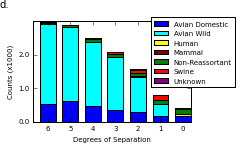

In [39]:
ind = sorted(hosts.keys()) #indices
# print(ind)
counts = dict() #counts of {'avian': [177, 460, 900...]}
for k1 in ind: #k1 is the degree of separation
#     print(k1)
    for k2 in hosts[k1]: #k2 is a host species
#         print(k2, hosts[k1][k2])
        if k2 not in counts.keys():
            counts[k2] = np.zeros(7)
            counts[k2][k1] = hosts[k1][k2]
        else:
            counts[k2][k1] = hosts[k1][k2]
# print(counts)
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
colors = ['b', 'purple', 'g', 'cyan', 'red', 'yellow', 'maroon']

bw = 0.7 #barwidth

sums = np.zeros(7)
for i in sorted(counts.keys()):
    ax.bar(ind, counts[i], bw, bottom=sums, label=i, color=colors[counts.keys().index(i)])
    sums = sums + counts[i]

ax.legend(loc='upper right', prop={'size':7}, bbox_to_anchor=(1,0,0.3,1.07))
ax.set_xticks(np.arange(0, 7, 1) + bw / 2)
ax.set_xticklabels(np.arange(0,7,1))
ax.set_xlabel('Degrees of Separation')
ax.set_ylabel('Counts (x1000)')
ax.set_yticks(np.arange(0, 2500, 1000))
ax.set_yticklabels(np.arange(0, 2.5, 1))
ax.invert_xaxis()

ax.annotate('d.', xy=(0,1), xycoords='figure fraction', ha='left', va='top')
plt.subplots_adjust(left=0.12, right=0.85,bottom=0.2)
plt.savefig('Proportion of Avian Reassortants.pdf', bbox_inches='tight')

In [40]:
sums

array([  402.,   802.,  1573.,  2092.,  2493.,  2881.,  2959.])

In [41]:
print(combined)

{0: [1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,

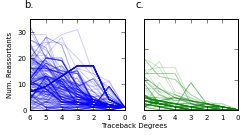

In [42]:
fig = plt.figure(figsize=(3.5, 1.75))
ax = fig.add_subplot(1,1,1)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
for c in deg_paths:
    xs = []
    ys = []
    for k, v in c.items():
        xs.append(k)
        ys.append(len(v))
    if ys[0] == 0:
        color='green'
        ax2.plot(xs, ys, alpha=0.2, color=color)
    else:
        color='blue'
        ax1.plot(xs, ys, alpha=0.2, color=color)

for spine in ax.spines.keys():
    ax.spines[spine].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])

ax1.set_ylabel('Num. Reassortants')
ax.set_xlabel('\nTraceback Degrees')
# ax2.annotate('Not Reassortant', xy=(0.2, 26), xycoords='data', ha='right', va='top', fontsize=8)
# ax1.annotate('Reassortant', xy=(0.2, 26), xycoords='data', ha='right', va='top', fontsize=8)
# ax1.set_xticks(np.arange(0, 7, 1))
# ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0, 31, 10))
ax2.set_yticks(np.arange(0, 31, 10))
ax2.set_yticklabels([])

ax1.invert_xaxis()
ax2.invert_xaxis()

ax1.annotate('b.', xy=(0.1,1), xycoords='figure fraction', ha='left', va='top')
ax2.annotate('c.', xy=(0.55, 1), xycoords='figure fraction', ha='left', va='top')
plt.subplots_adjust(right=0.95, bottom=0.18, top=0.90)
plt.savefig('Traceback Reassortant Virus Counts.pdf')

In [43]:
# What are the reassortment source-sink interfaces that were found?
interface_counts = Counter()


for n, d in G.nodes(data=True):
    if is_reassortant(G, n):
        sink_host = d['host_species']
        sink_hg = get_host_group(G, n)
        sink_ecotype = d['ecotype']
        sink_subtype = d['subtype']
        if sink_hg == 'Avian':
            sink_hg = '{0} Avian'.format(sink_ecotype)
        for source in  G.predecessors(n):
            source_d = G.node[source]
            source_host = source_d['host_species']
            source_hg = get_host_group(G, source)
            source_ecotype = source_d['ecotype']
            source_subtype = source_d['subtype']
            
            if source_hg == 'Avian':
                source_hg = '{0} Avian'.format(source_ecotype)
            
            interface_counts['{0}->{1}'.format(source_hg, sink_hg)] += 1

In [44]:
[(k,v) for k, v in interface_counts.items() if 'Swine' in k]

[('Unknown Avian->Swine', 5),
 ('Wild Avian->Swine', 53),
 ('Swine->Human', 306),
 ('Unknown->Swine', 1),
 ('Domestic Avian->Swine', 17),
 ('Mammal->Swine', 3),
 ('Swine->Domestic Avian', 9),
 ('Swine->Unknown Avian', 5),
 ('Swine->Swine', 353),
 ('Swine->Wild Avian', 3),
 ('Domestic  Avian->Swine', 1),
 ('Human->Swine', 108)]

# Random note 16 April 2015

There are same-subtype reassortant interactions, then there are same-subtype whole genome interactions.

Need to tease these two apart.

In [45]:
host_jump_subtype_interaction_counts = Counter()

